<a href="https://colab.research.google.com/github/3778/COVID-19/blob/master/notebooks/%5Bissue_50%5D_Estimate_reproduction_number.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

# Check if we are in colab before cloning git repo.
IN_COLAB = 'google.colab' in sys.modules
CURRENT_DIR = !pwd

if IN_COLAB and not CURRENT_DIR[0].endswith('COVID-19/notebooks'):
    !git clone -l -s git://github.com/3778/COVID-19.git
    %cd COVID-19/notebooks
    !ls
else:
    print(f'Did not clone, already in directory {CURRENT_DIR[0]}')

Cloning into 'COVID-19'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 978 (delta 38), reused 60 (delta 21), pack-reused 888
Receiving objects: 100% (978/978), 2.06 MiB | 2.22 MiB/s, done.
Resolving deltas: 100% (484/484), done.
/content/COVID-19/notebooks
 covid19
 Dados_Ceara.ipynb
 estimate_reproduction_number.ipynb
'[Issue_30]_Simulador_Leitos.ipynb'
'[issue_36]_Tunar_parâmetros_com_dados_histórico.ipynb'
'[issue_62]_Covid_Auto_Arima.ipynb'
 simulacao_filas_hospital.ipynb


In [0]:
import sys
import os
# insert at 1, 0 is the script path (or '' in REPL)
base_dir = '/'.join(os.getcwd().split('/')[:-1])
sys.path.insert(0, base_dir)

from covid19.estimation import ReproductionNumber
import pandas as pd
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from copy import deepcopy


%load_ext rpy2.ipython

In [0]:
t_max = 5
window_width = 6
N = 100_000

In [0]:
def run_Rt_estimation(incidence, prior_shape, prior_scale, mean_si, sd_si, t_max, window_width):
    
    si_pars = {'mean': mean_si, 'sd': sd_si}
    
    Rt = ReproductionNumber(incidence=incidence,
                            si_pars=si_pars,
                            prior_shape=prior_shape, 
                            prior_scale=prior_scale,
                            window_width=window_width
                           )
    
    Rt.compute_posterior_parameters()

    Rt_posterior_sample = Rt.sample_from_posterior(sample_size=N)
    Rt.compute_posterior_summaries(posterior_sample=Rt_posterior_sample, t_max=t_max)

    results = Rt
    
    return results

### Prior predictive check (sort of)

#### Rt prior

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



    2.5%      25%      75%    97.5% 
1.084074 2.223372 4.110055 6.663503 
mean = 3.27956140699521, sd = 1.4491862202094
shape = 5.11695600475624, scale = 0.641006097560976


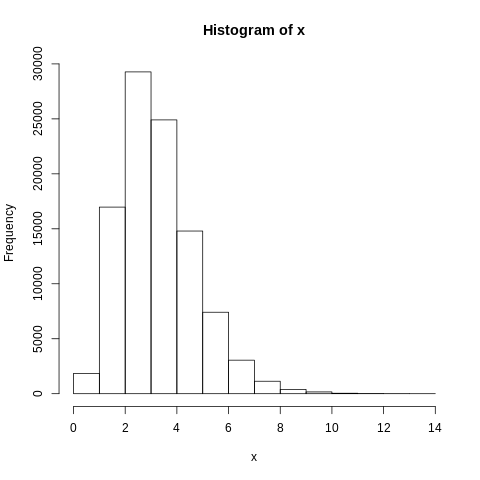

In [5]:
%%R

library(tidyverse)

f <- function(shape=NULL, scale=NULL, mu=NULL, sd=NULL) {
    if (!is.null(mu)) {
        shape = (mu/sd)^2
        scale = (sd^2)/mu
    }
    x <- rgamma(1e5, shape = shape, scale = scale)
    print(quantile(x, prob = c(.025, .25, .75, .975)))
    print(str_glue("mean = {mean(x)}, sd = {sd(x)}"))
    print(str_glue("shape = {shape}, scale = {scale}"))
    hist(x)
}

f(mu=3.28, sd=1.45)

#### SI distribution

     2.5%       25%       75%     97.5% 
 2.384825  5.021004  9.418286 15.413872 
mean = 7.49323053774569, sd = 3.38683624791949
shape = 4.8659169550173, scale = 1.54133333333333


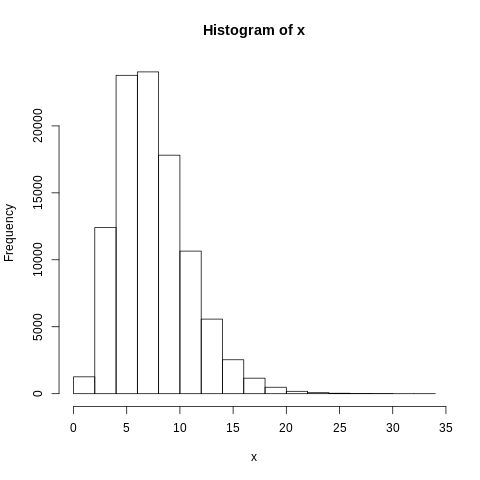

In [6]:
%%R

f(mu = 7.5, sd = 3.4)

# Results

## Brazil - get data

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv')
data['date'] = data['date'].astype('datetime64[ns]')

def get_incidence_data(data, region):
    incidence = data[data['state'] == region][['date', 'newCases', 'totalCases']]
    incidence = incidence.set_index('date')
    
    incidence = (incidence.asfreq('d')
                 .assign(newCases=lambda x: x.newCases.fillna(0),
                         totalCases=lambda x: x.totalCases.fillna(method='ffill'))
                 .query('totalCases >= 50'))
    incidence = incidence.reset_index()
    incidence.columns = ['dates', 'incidence', 'totalCases']
    incidence = incidence.set_index('dates')
    
    return incidence[['incidence']]


brazil_incidence = get_incidence_data(data=data, region="TOTAL")

### Brazil - estimate

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


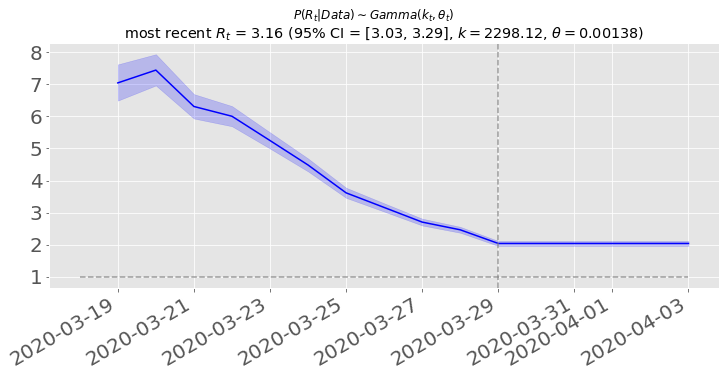

In [8]:


brazil_results = run_Rt_estimation(incidence=brazil_incidence,
                                   prior_shape=5.12, prior_scale=0.64,
                                   mean_si=7.5, sd_si=3.4,
                                   t_max=t_max, window_width=window_width)

last_known_day = brazil_results.posterior_summary.query('end_dates == "2020-03-26"')

most_recent_Rt = last_known_day['Rt_mean'].round(2).values[0]
upper = last_known_day['Rt_q0.975'].round(2).values[0]
lower = last_known_day['Rt_q0.025'].round(2).values[0]
brazil_posterior_shape = last_known_day['Rt_shape'].values[0]
brazil_posterior_scale = last_known_day['Rt_scale'].values[0]
title = f"most recent $R_t$ = {most_recent_Rt} (95% CI = [{lower}, {upper}], $k = {round(brazil_posterior_shape, 2)}$, $\\theta = {round(brazil_posterior_scale, 5)}$)"

brazil_results.plot_reproduction_number(title=title)

## Check whether R package agrees

In [9]:
%%R -i brazil_incidence -h 300 -w 800

library(EpiEstim)
library(patchwork)
library(tidyverse)

df <- data.frame(incidence = brazil_incidence)

window_size <- 6
t_start = seq(2, nrow(df) - window_size, 1)
res <- estimate_R(
    df, 
    method="parametric_si",
    config = make_config(list(mean_si = 7.5, std_si = 3.4,
                              mean_prior = 3.3, std_prior=1.45,
                              t_start = t_start, t_end = t_start + window_size ))
)


p2 <- plot(res, what = "R")
p2 <- p2 +  geom_text(
         data = . %>% filter(end == 16),
         aes(label = paste0("most recent Rt = ", round(meanR, 2)),
             x = 5, y = 2)
         )

cat(paste0("implied R0 ",mean(res$R[, 3])))

p2

R[write to console]: Error in library(EpiEstim) : there is no package called ‘EpiEstim’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library




Error in library(EpiEstim) : there is no package called ‘EpiEstim’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library


## Run for each state

In [0]:
def plot_results(results, region, filename):
    d = results.posterior_summary
    last_fitted_day = max(d[d['estimation_type'] == "fitted"]["end_dates"])
    last_fitted_day = d.query(f'end_dates == "{last_fitted_day}"')
    n = results.incidence.shape[0]

    most_recent_Rt = last_fitted_day['Rt_mean'].round(2).values[0]
    upper = last_fitted_day['Rt_q0.975'].round(2).values[0]
    lower = last_fitted_day['Rt_q0.025'].round(2).values[0]
    posterior_shape = last_fitted_day['Rt_shape'].values[0]
    posterior_scale = last_fitted_day['Rt_scale'].values[0]
    title = f"{region}: most recent $R_t$ = {most_recent_Rt} (95% CI = [{lower}, {upper}], n = {n}, $k = {round(posterior_shape, 2)}$, $\\theta = {round(posterior_scale, 5)}$)"

    results.plot_reproduction_number(title=title, filename=filename)


In [0]:
states = list(set([i for i in data['state'] if i != "TOTAL"]))

state_results = {}
for state in states:
    incidence = get_incidence_data(data=data, region=state)
    n = incidence.shape[0]
    if n > 7:
        results = run_Rt_estimation(incidence=incidence,
                                    prior_shape=brazil_posterior_shape, # uses most recent Rt distc import ReproductionNumber from Brazil posterior
                                    prior_scale=brazil_posterior_scale,
                                    mean_si=7.5, sd_si=3.4,
                                    t_max=t_max, window_width=window_width)
        results.posterior_summary['source'] = 'own data'
    else:
        # when too few data points, use brazils results
        results = deepcopy(brazil_results)
        results.posterior_summary['source'] = 'Brazil data'
    plot_results(results=results,
                 region=state,
                 filename=f'{state}.png')
    results.posterior_summary['state'] = state
    results.posterior_summary['R0'] = (results.posterior_summary
                                       .query('estimation_type == "fitted"')['Rt_mean'].mean())
    results.posterior_summary['R0_sd'] = (results.posterior_summary
                                          .query('estimation_type == "fitted"')['Rt_sd'].std())
    results.posterior_summary['n'] = n

    state_results[state] = results


In [12]:
states_summary = pd.concat([v.posterior_summary for _, v in state_results.items()], ignore_index=True)
states_summary

,start_dates,end_dates,Rt_mean,Rt_sd,Rt_q0.975,Rt_q0.025,Rt_shape,Rt_scale,estimation_type,source,state,R0,R0_sd,n
0,2020-03-12,2020-03-18,NaN,NaN,NaN,NaN,NaN,NaN,fitted,Brazil data,RN,4.591781,0.085057,1
1,2020-03-13,2020-03-19,7.042844,0.288575,7.618913,6.489639,590.12,0.011934,fitted,Brazil data,RN,4.591781,0.085057,1
2,2020-03-14,2020-03-20,7.441464,0.248444,7.935701,6.962350,897.12,0.008294,fitted,Brazil data,RN,4.591781,0.085057,1
3,2020-03-15,2020-03-21,6.307721,0.193932,6.692618,5.933077,1063.12,0.005933,fitted,Brazil data,RN,4.591781,0.085057,1
4,2020-03-16,2020-03-22,6.002832,0.160822,6.320314,5.691041,1394.12,0.004306,fitted,Brazil data,RN,4.591781,0.085057,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,NaT,2020-03-30,2.038924,0.039334,2.116883,1.962433,2683.12,0.000760,forecasted,Brazil data,PA,4.591781,0.085057,0
379,NaT,2020-03-31,2.038924,0.039334,2.116883,1.962433,2683.12,0.000760,forecasted,Brazil data,PA,4.591781,0.085057,0
380,NaT,2020-04-01,2.038924,0.039334,2.116883,1.962433,2683.12,0.000760,forecasted,Brazil data,PA,4.591781,0.085057,0
381,NaT,2020-04-02,2.038924,0.039334,2.116883,1.962433,2683.12,0.000760,forecasted,Brazil data,PA,4.591781,0.085057,0


In [13]:
import numpy as np
brazil_summary = brazil_results.posterior_summary
brazil_summary['state'] = 'Brazil'  # well....query('estimation_type == "fitted"')['Rt_mean'].mean()
brazil_summary['R0'] = brazil_summary.query('estimation_type == "fitted"')['Rt_mean'].mean()
brazil_summary['R0_sd'] = brazil_summary.query('estimation_type == "fitted"')['Rt_mean'].std()
brazil_summary['n'] = brazil_results.incidence.shape[0]
brazil_summary

,start_dates,end_dates,Rt_mean,Rt_sd,Rt_q0.975,Rt_q0.025,Rt_shape,Rt_scale,estimation_type,state,R0,R0_sd,n
0,2020-03-12,2020-03-18,NaN,NaN,NaN,NaN,NaN,NaN,fitted,Brazil,4.591781,1.926396,19
1,2020-03-13,2020-03-19,7.042844,0.288575,7.618913,6.489639,590.12,0.011934,fitted,Brazil,4.591781,1.926396,19
2,2020-03-14,2020-03-20,7.441464,0.248444,7.935701,6.962350,897.12,0.008294,fitted,Brazil,4.591781,1.926396,19
3,2020-03-15,2020-03-21,6.307721,0.193932,6.692618,5.933077,1063.12,0.005933,fitted,Brazil,4.591781,1.926396,19
4,2020-03-16,2020-03-22,6.002832,0.160822,6.320314,5.691041,1394.12,0.004306,fitted,Brazil,4.591781,1.926396,19
5,2020-03-17,2020-03-23,5.246505,0.128774,5.501481,4.996803,1663.12,0.003154,fitted,Brazil,4.591781,1.926396,19
6,2020-03-18,2020-03-24,4.483876,0.102383,4.687481,4.284274,1912.12,0.002345,fitted,Brazil,4.591781,1.926396,19
7,2020-03-19,2020-03-25,3.616003,0.080338,3.775356,3.459987,2037.12,0.001775,fitted,Brazil,4.591781,1.926396,19
8,2020-03-20,2020-03-26,3.160884,0.065975,3.290610,3.032081,2298.12,0.001375,fitted,Brazil,4.591781,1.926396,19
9,2020-03-21,2020-03-27,2.704421,0.054263,2.811875,2.598833,2466.12,0.001097,fitted,Brazil,4.591781,1.926396,19


In [14]:
final_summary = pd.concat([states_summary, brazil_summary], ignore_index=True)
final_summary = final_summary[final_summary.notna()["Rt_mean"]].reset_index()
final_summary

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,index,R0,R0_sd,Rt_mean,Rt_q0.025,Rt_q0.975,Rt_scale,Rt_sd,Rt_shape,end_dates,estimation_type,n,source,start_dates,state
0,1,4.591781,0.085057,7.042844,6.489639,7.618913,0.011934,0.288575,590.12,2020-03-19,fitted,1,Brazil data,2020-03-13,RN
1,2,4.591781,0.085057,7.441464,6.962350,7.935701,0.008294,0.248444,897.12,2020-03-20,fitted,1,Brazil data,2020-03-14,RN
2,3,4.591781,0.085057,6.307721,5.933077,6.692618,0.005933,0.193932,1063.12,2020-03-21,fitted,1,Brazil data,2020-03-15,RN
3,4,4.591781,0.085057,6.002832,5.691041,6.320314,0.004306,0.160822,1394.12,2020-03-22,fitted,1,Brazil data,2020-03-16,RN
4,5,4.591781,0.085057,5.246505,4.996803,5.501481,0.003154,0.128774,1663.12,2020-03-23,fitted,1,Brazil data,2020-03-17,RN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,395,4.591781,1.926396,2.038924,1.962433,2.116883,0.000760,0.039334,2683.12,2020-03-30,forecasted,19,NaN,NaT,Brazil
376,396,4.591781,1.926396,2.038924,1.962433,2.116883,0.000760,0.039334,2683.12,2020-03-31,forecasted,19,NaN,NaT,Brazil
377,397,4.591781,1.926396,2.038924,1.962433,2.116883,0.000760,0.039334,2683.12,2020-04-01,forecasted,19,NaN,NaT,Brazil
378,398,4.591781,1.926396,2.038924,1.962433,2.116883,0.000760,0.039334,2683.12,2020-04-02,forecasted,19,NaN,NaT,Brazil


In [0]:
final_summary.to_csv('covid_reproduction_number_estimates.csv', index=False)